# [T6] Advanced methods for neural end-to-end speech processing – unification, integration, and <span style="color:red">implementation</span> -

**PART3: Building End-to-End ASR System**

Speaker: [Shigeki Karita](https://github.com/ShigekiKarita)

NTT Communication Science Laboratories

15, September, 2019


<span style="color:gray">1. Introduction to End-to-End Speech Processing (25 min.)</span> Watanabe

<span style="color:gray">2. End-to-End Integration of Multiple Speech Applications (50 min.)</span> Hori

coffee break

<span style="color:red">3. Building End-to-End ASR System (30 min.)</span> Karita

<span style="color:gray">4. Building End-to-End TTS System (30 min.)</span> Hayashi

<span style="color:gray">5. Conclusion and Future Research Directions (30 min)</span> Watanabe


## Abstract

How to build end-to-end ASR systems using ESPnet.

Unlike the previous ones, part 3 and 4 focus on implementation.

### materials

- This slide https://github.com/espnet/interspeech2019-tutorial
- API documetation https://espnet.github.io/espnet/
- Runnable demo https://colab.research.google.com/drive/1YA8Cf3_mX41Ku5D01bHOynzDw9gIyWEa


## Colab

Runnable demo https://colab.research.google.com/drive/1YA8Cf3_mX41Ku5D01bHOynzDw9gIyWEa
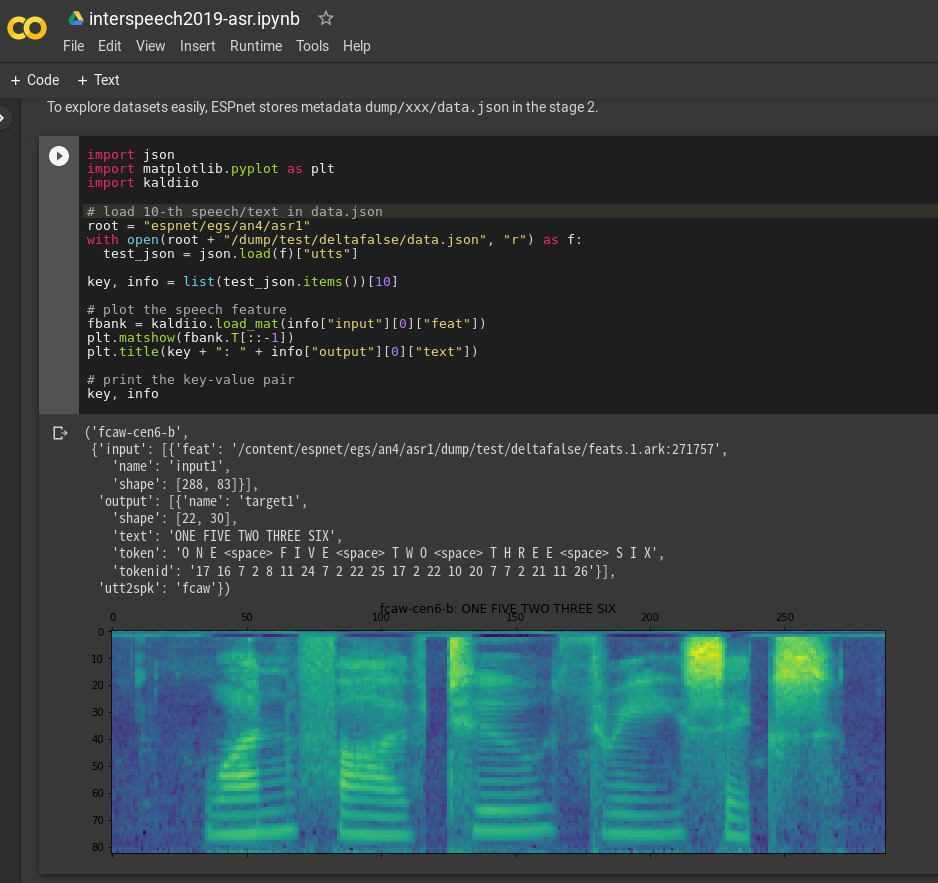

## TOC

1. Overview
1. Installation
1. Use ESPnet in Bash
1. Use ESPnet in Python
1. Extend ESPnet
1. Summary

# 1. Overview

ESPnet provides a **python library and bash recipes** for speech processing.

important directories in ESPnet

- espnet: python library root
- egs: Kaldi-style examples
- tools: third-party dependencies
- utils: helper shell scripts used in egs

## 1.1 Python library

- Python 3.7
- Neural network libraries
  - PyTorch
  - Chainer
- Automatically tested
  - Coverage 78% https://codecov.io/gh/espnet/espnet
  - Linux distributions: Ubuntu/Debian/CentOS https://circleci.com/gh/espnet/espnet
  - Sphinx documentation https://espnet.github.io/espnet/

## 1.2 Bash recipes

ESPnet supports total 34 ASR tasks including

- Multilingual ASR: en, zh, ja, etc
- Noise robust and far-field ASR
- Multi-ch ASR: joint training with speech enhancement
- Speech Translation: transfer learning from ASR and MT

For more detail:
https://github.com/espnet/espnet/tree/master/egs


## 1.3 ASR Performance

On free corpora, ESPnet achieved:

- Aishell (zh): CER test: 6.7%
- Common Voice (en): WER test: 2.3%
- LibriSpeech (en): WER test-clean: 2.6%, test-other 5.7%
- TED-LIUM2 (en): WER test: 8.1%

**Pretrained models are available**

https://github.com/espnet/espnet#asr-results


# 2. Installation

ESPnet depends on Kaldi ASR toolkit and Warp-CTC.

You can install them manually or

```
$ cd espnet/tools; make
```

## 2.1 Installation (Google colab)

TODO: replace these script with a single script

In Google colab, we can use prebuilt Kaldi for faster startup:

In [ ]:
# OS setup
!sudo apt-get install bc tree

# espnet setup
!git clone https://github.com/espnet/espnet
!cd espnet; pip install -e .
!mkdir -p espnet/tools/venv/bin; touch espnet/tools/venv/bin/activate

# warp ctc setup
!git clone https://github.com/espnet/warp-ctc -b pytorch-1.1
!cd warp-ctc && mkdir build && cd build && cmake .. && make -j4
!cd warp-ctc/pytorch_binding && python setup.py install 

# kaldi setup
!cd ./espnet/tools; git clone https://github.com/kaldi-asr/kaldi
!echo "" > ./espnet/tools/kaldi/tools/extras/check_dependencies.sh # ignore check
!chmod +x ./espnet/tools/kaldi/tools/extras/check_dependencies.sh
!cd ./espnet/tools/kaldi/tools; make sph2pipe sclite
!rm -rf espnet/tools/kaldi/tools/python
![ ! -e ubuntu16-featbin.tar.gz ] && wget https://18-198329952-gh.circle-artifacts.com/0/home/circleci/repo/ubuntu16-featbin.tar.gz
!tar -xf ./ubuntu16-featbin.tar.gz
!cp featbin/* espnet/tools/kaldi/src/featbin/

In [12]:
!ls espnet/egs/an4/asr1

cmd.sh	conf  local  path.sh  RESULTS  run.sh  steps  utils


# 3. Use ESPnet in Bash

`espnet/egs/*/asr1/run.sh` reproduces our results.

It consits of common stages:
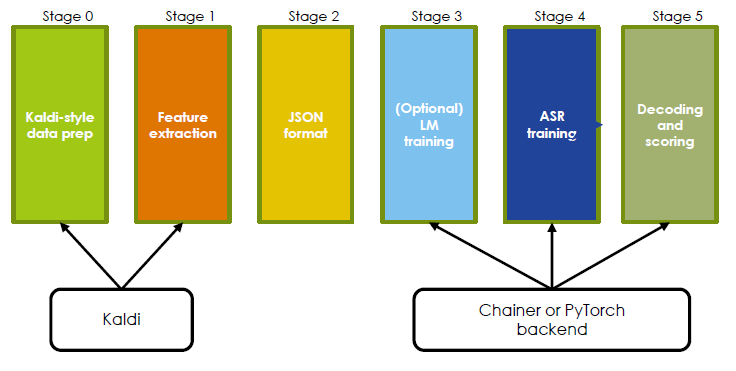

## 3.1 Kaldi-style directory structure

Always we organize each recipe placed in `egs/xxx/asr1` in Kaldi way:

- `data/`: raw [data prepared by Kaldi](https://kaldi-asr.org/doc/data_prep.html)
- `dump/`: python-friendly dataset (e.g., json, hdf5)
- `exp/`: log files and saved model parameters
- `conf/`: configurations for scripts and machines (e.g., Local, SLURM, SGE)


In [5]:
!tree -L 1 espnet/egs/an4/asr1

espnet/egs/an4/asr1
├── cmd.sh
├── conf
├── local
├── path.sh
├── RESULTS
├── run.sh
├── steps -> ../../../tools/kaldi/egs/wsj/s5/steps
└── utils -> ../../../tools/kaldi/egs/wsj/s5/utils

4 directories, 4 files



## 3.2 Data preparation (Stage 0 - 2)

For example, if you add `--stop-stage 2`, you can stop the script before neural network training.

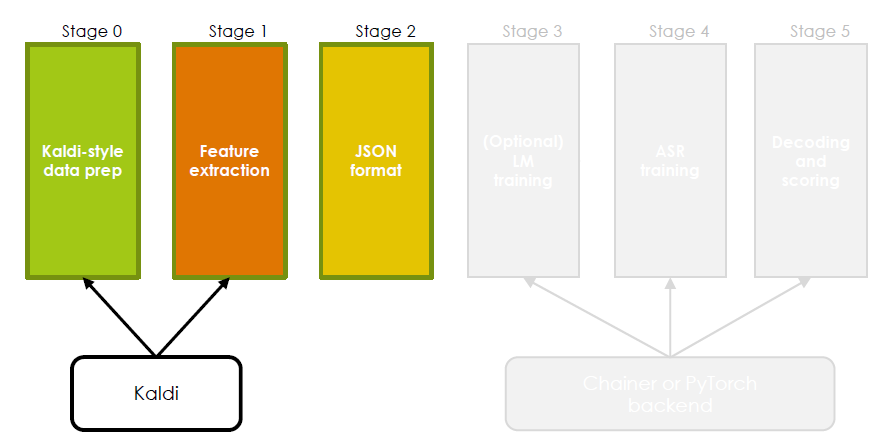

In [71]:
!cd espnet/egs/an4/asr1; ./run.sh  --ngpu 1 --stop-stage 2

stage -1: Data Download
local/download_and_untar.sh: an4 directory already exists in ./downloads
stage 0: Data preparation
stage 1: Feature Generation
steps/make_fbank_pitch.sh --cmd run.pl --nj 8 --write_utt2num_frames true data/test exp/make_fbank/test fbank
steps/make_fbank_pitch.sh: moving data/test/feats.scp to data/test/.backup
utils/validate_data_dir.sh: Successfully validated data-directory data/test
steps/make_fbank_pitch.sh: [info]: no segments file exists: assuming wav.scp indexed by utterance.
Succeeded creating filterbank & pitch features for test
fix_data_dir.sh: kept all 130 utterances.
fix_data_dir.sh: old files are kept in data/test/.backup
steps/make_fbank_pitch.sh --cmd run.pl --nj 8 --write_utt2num_frames true data/train exp/make_fbank/train fbank
steps/make_fbank_pitch.sh: moving data/train/feats.scp to data/train/.backup
utils/validate_data_dir.sh: Successfully validated data-directory data/train
steps/make_fbank_pitch.sh: [info]: no segments file exists: assuming

### What is data preparation?

ESPnet requires only two paired files: 
- speech wav: `data/{train,dev,test}/wav.scp`
- transcription text: `data/{train,dev,test}/text`

### speech wav.scp

```
<utt-id1> <command1> ...
<utt-id2> <command2> ...
...
<utt-id3> <command3> ...
```

In [13]:
!head espnet/egs/an4/asr1/data/train/wav.scp

fash-an251-b /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/interspeech2019-tutorial/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an251-fash-b.sph |
fash-an253-b /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/interspeech2019-tutorial/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an253-fash-b.sph |
fash-an254-b /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/interspeech2019-tutorial/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an254-fash-b.sph |
fash-an255-b /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/interspeech2019-tutorial/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an255-fash-b.sph |
fash-cen1-b /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/interspeech2019-tutorial/espnet/egs/an4/

### transcription text

```
<utt-id1> <text1>
<utt-id2> <text2>
...
<utt-id3> <text3>
```

In [14]:
!head espnet/egs/an4/asr1/data/train/text

fash-an251-b YES
fash-an253-b GO
fash-an254-b YES
fash-an255-b U M N Y H SIX
fash-cen1-b H I N I C H
fash-cen2-b A M Y
fash-cen4-b M O R E W O O D
fash-cen5-b P I T T S B U R G H
fash-cen7-b TWO SIX EIGHT FOUR FOUR ONE EIGHT
fbbh-an86-b C Z D Z W EIGHT


## 3.3 NN Training (Stage 3 - 4)

You can configure NN training with `conf/train_xxx.yaml`

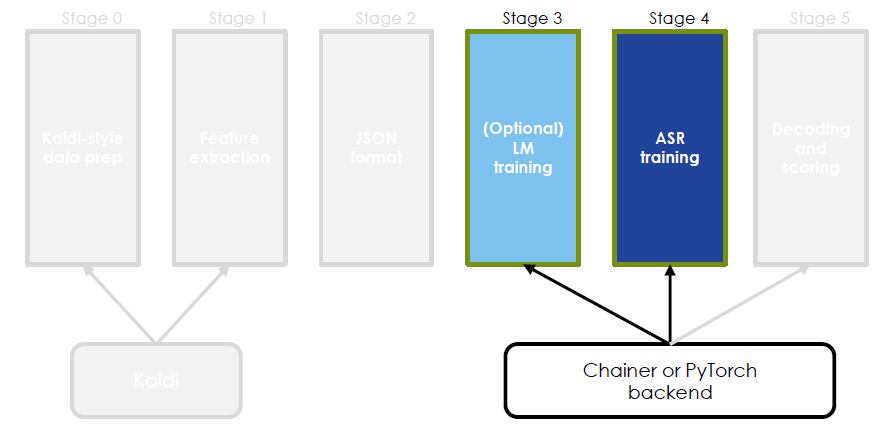

In [15]:
!tail espnet/egs/an4/asr1/conf/train_mtlalpha0.5.yaml

dlayers: 1
dunits: 300
# attention related
atype: location
adim: 320
aconv-chans: 10
aconv-filts: 100

# hybrid CTC/attention
mtlalpha: 0.5


In [16]:
!cd espnet/egs/an4/asr1; ./run.sh  --ngpu 1 --stage 3 --stop-stage 4 --train-config ./conf/train_mtlalpha0.5.yaml

dictionary: data/lang_1char/train_nodev_units.txt
stage 3: LM Preparation
stage 4: Network Training


### TIPS: change_yaml.py

For rapid experiments, tweak the config by **$(change_yaml.py train.yaml -a lr=0.01)**

In [0]:
!cd espnet/egs/an4/asr1; source path.sh; \
  ./run.sh  --ngpu 1 --stage 4 --stop-stage 4 \
  --train-config $(change_yaml.py ./conf/train_mtlalpha1.0.yaml -a eunits=100)

dictionary: data/lang_1char/train_nodev_units.txt
stage 4: Network Training


### TIPS: tensorboard

To find the best config, view tensorboard

In [0]:
!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
%load_ext tensorboard 
%tensorboard --logdir espnet/egs/an4/asr1/tensorboard

Reusing TensorBoard on port 6006 (pid 12588), started 0:40:18 ago. (Use '!kill 12588' to kill it.)

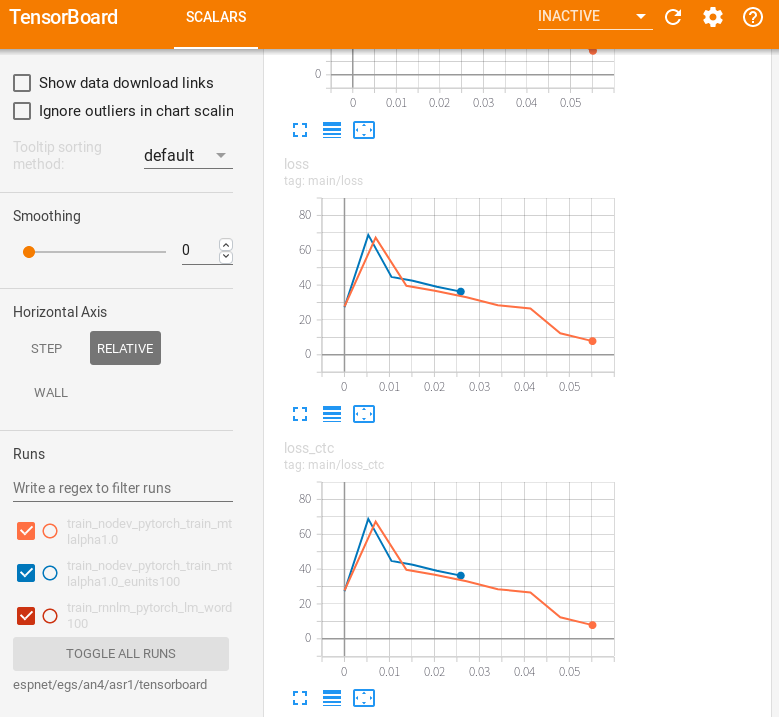

## 3.4 Decoding and evaluation (Stage 5)

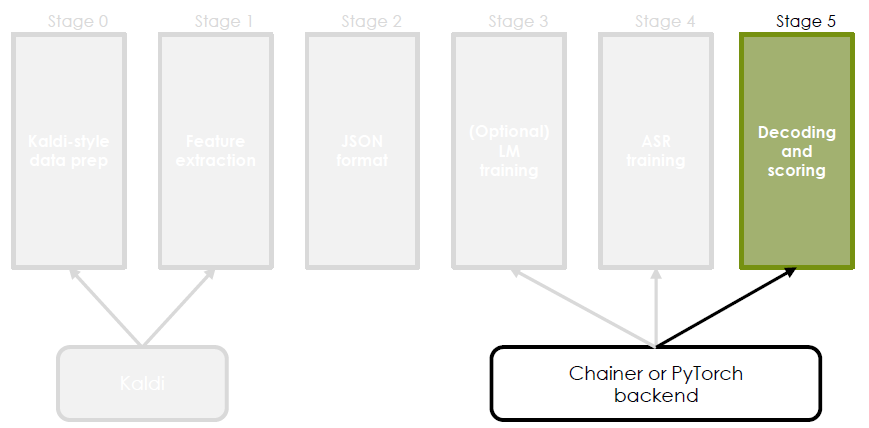

decoding YAML config similar to training YAML

In [25]:
!cat espnet/egs/an4/asr1/conf/decode_ctcweight0.5.yaml

# decoding parameter
beam-size: 20
penalty: 0.0
maxlenratio: 0.0
minlenratio: 0.0
ctc-weight: 0.5
lm-weight: 1.0


In [28]:
%%bash
cd espnet/egs/an4/asr1
source path.sh
./run.sh --stage 5 --decode-config $(change_yaml.py conf/decode_ctcweight0.5.yaml -a batchsize=0) --train-config conf/train_mtlalpha0.5.yaml

dictionary: data/lang_1char/train_nodev_units.txt
stage 5: Decoding
write a CER (or TER) result in exp/train_nodev_pytorch_train_mtlalpha0.5/decode_train_dev_decode_ctcweight0.5_batchsize0_lm_word100/result.txt
|   SPKR      |   # Snt      # Wrd    |   Corr         Sub        Del         Ins         Err       S.Err    |
|   Sum/Avg   |    100        1915    |   80.5         7.9       11.6         0.8        20.3        71.0    |
write a CER (or TER) result in exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_batchsize0_lm_word100/result.txt
|   SPKR     |   # Snt      # Wrd   |   Corr        Sub         Del        Ins        Err       S.Err   |
|   Sum/Avg  |    130        2565   |   87.7        6.4         6.0        0.8       13.1        56.9   |


2019-09-08 18:24:49,521 (splitjson:40) INFO: /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/espnet/tools/venv/bin/python3 /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/interspeech2019-tutorial/espnet/egs/an4/asr1/../../../utils/splitjson.py --parts 8 dump/test/deltafalse/data.json
2019-09-08 18:24:49,521 (splitjson:40) INFO: /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/espnet/tools/venv/bin/python3 /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/interspeech2019-tutorial/espnet/egs/an4/asr1/../../../utils/splitjson.py --parts 8 dump/train_dev/deltafalse/data.json
2019-09-08 18:24:49,521 (splitjson:52) INFO: number of utterances = 100
2019-09-08 18:24:49,521 (splitjson:52) INFO: number of utterances = 130
2019-09-08 18:28:03,797 (concatjson:36) INFO: /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/espnet/tools/venv/bin/python3 /mnt/ae0fa180-1e4d-4945-8f63-f64615d07b30/repos/interspeech2019-tutorial/espnet/egs/an4/asr1/../../../utils/concatjson.py exp/train_nodev_pytorch_train_mtlal

CalledProcessError: Command 'b'cd espnet/egs/an4/asr1\nsource path.sh\n./run.sh --stage 5 --decode-config $(change_yaml.py conf/decode_ctcweight0.5.yaml -a batchsize=0) --train-config conf/train_mtlalpha0.5.yaml\n'' returned non-zero exit status 1.

## 3.5 Check evaluation results

ESPnet uses `sclite` to evaluate ASR errors

- token error rate: exp/(train dir)/(decode dir)/result.txt
- word error rate: exp/(train dir)/(decode dir)/result.wrd.txt

In [44]:
!grep -e Avg -e SPK -m 2 espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha0.5/*/result.txt

espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_batchsize0_lm_word100/result.txt:|   SPKR     |   # Snt      # Wrd   |   Corr        Sub         Del        Ins        Err       S.Err   |
espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_batchsize0_lm_word100/result.txt:|   Sum/Avg  |    130        2565   |   87.7        6.4         6.0        0.8       13.1        56.9   |
espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha0.5/decode_train_dev_decode_ctcweight0.5_batchsize0_lm_word100/result.txt:|   SPKR      |   # Snt      # Wrd    |   Corr         Sub        Del         Ins         Err       S.Err    |
espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha0.5/decode_train_dev_decode_ctcweight0.5_batchsize0_lm_word100/result.txt:|   Sum/Avg   |    100        1915    |   80.5         7.9       11.6         0.8        20.3        71.0    |


In [41]:
!head -n 36 espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_batchsize0_lm_word100/result.txt




                     SYSTEM SUMMARY PERCENTAGES by SPEAKER                      

,-------------------------------------------------------------------------------------------------------.
|exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_batchsize0_lm_word100/hyp.trn|
|-------------------------------------------------------------------------------------------------------|
|   SPKR     |   # Snt      # Wrd   |   Corr        Sub         Del        Ins        Err       S.Err   |
|------------+----------------------+-------------------------------------------------------------------|
|   fcaw     |     13         237   |   89.9        8.9         1.3        1.3       11.4        53.8   |
|------------+----------------------+-------------------------------------------------------------------|
|   fjlp     |     13         242   |   89.3        8.7         2.1        0.4       11.2        53.8   |
|------------+----------------------+------------------------------

In [42]:
!tail -n 36 espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_batchsize0_lm_word100/result.txt

Scores: (#C #S #D #I) 7 0 0 0
REF:  a <space> s e v e n 
HYP:  a <space> s e v e n 
Eval:                     

id: (mmxg-mmxg-cen4-b)
Scores: (#C #S #D #I) 22 3 6 0
REF:  m <space> a <space> r <space> G <space> a <space> r <SPACE> E <space> T <space> M <space> o <SPACE> R <space> r <space> i <space> s <SPACE> O <space> n 
HYP:  m <space> a <space> r <space> D <space> a <space> r ******* * <space> O <space> N <space> o ******* * <space> r <space> i <space> s ******* * <space> n 
Eval:                               S                     D       D         S         S           D       D                               D       D           

id: (mmxg-mmxg-cen5-b)
Scores: (#C #S #D #I) 19 0 0 0
REF:  p <space> i <space> t <space> t <space> s <space> b <space> u <space> r <space> g <space> h 
HYP:  p <space> i <space> t <space> t <space> s <space> b <space> u <space> r <space> g <space> h 
Eval:                                                                                             

id: 

### ASR result as `data.json`

Find detail results in `exp/xxx/decode_yyy/data.json`

In [0]:
!head -n20 espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha1.0/decode_test_decode_ctcweight1.0_lm_word100/data.json

{
    "utts": {
        "fcaw-an406-b": {
            "output": [
                {
                    "name": "target1[1]",
                    "rec_text": "<blank><blank><blank>RUBOU<blank>T<blank><blank><blank> T N E F THREE NINE<eos>",
                    "rec_token": "<blank> <blank> <blank> R U B O U <blank> T <blank> <blank> <blank> <space> T <space> N <space> E <space> F <space> T H R E E <space> N I N E <eos>",
                    "rec_tokenid": "0 0 0 20 23 4 17 23 0 22 0 0 0 2 22 2 16 2 7 2 8 2 22 10 20 7 7 2 16 11 16 7 29",
                    "score": -1.0287089347839355,
                    "shape": [
                        25,
                        30
                    ],
                    "text": "RUBOUT G M E F THREE NINE",
                    "token": "R U B O U T <space> G <space> M <space> E <space> F <space> T H R E E <space> N I N E",
                    "tokenid": "20 23 4 17 23 22 2 9 2 15 2 7 2 8 2 22 10 20 7 7 2 16 11 16 7"
                }
          

# 4. Use ESPnet in Python

1. Load the speech features
2. Load the pretrained model
3. Recognize the speech by the model
4. Visualizations (attention, ctc)

### 4.1 Load speech features

Text(0.5, 1.05, 'fcaw-cen6-b: ONE FIVE TWO THREE SIX')

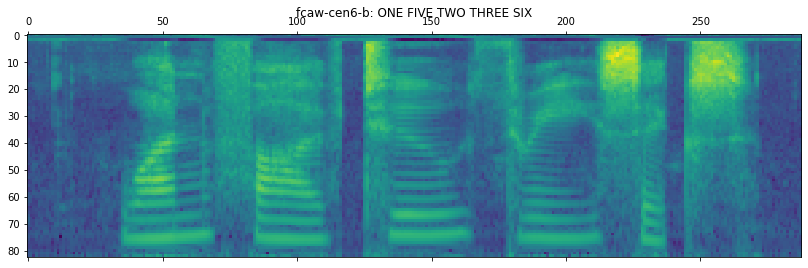

In [17]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import kaldiio

# ESPnet summarizes dataset to JSON
root = "espnet/egs/an4/asr1"
with open(root + "/dump/test/deltafalse/data.json", "r") as f:
    test_json = json.load(f)["utts"]

key, info = list(test_json.items())[10]
fbank = kaldiio.load_mat(info["input"][0]["feat"])

# plot the speech feature
plt.matshow(fbank.T[::-1])
plt.title(key + ": " + info["output"][0]["text"])

## 4.2 Load pretrained model

In [70]:
!ls espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha0.5/results

acc.png		model.json	 snapshot.ep.13  snapshot.ep.19  snapshot.ep.6
att_ws		model.loss.best  snapshot.ep.14  snapshot.ep.2	 snapshot.ep.7
cer.png		snapshot.ep.1	 snapshot.ep.15  snapshot.ep.20  snapshot.ep.8
log		snapshot.ep.10	 snapshot.ep.16  snapshot.ep.3	 snapshot.ep.9
loss.png	snapshot.ep.11	 snapshot.ep.17  snapshot.ep.4
model.acc.best	snapshot.ep.12	 snapshot.ep.18  snapshot.ep.5


In [43]:
import json
import torch
from espnet.nets.pytorch_backend.e2e_asr import E2E

# pretrained dir
model_dir = "espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha0.5/results"

# load model
with open(model_dir + "/model.json", "r") as f:
    idim, odim, conf = json.load(f)
model = E2E.build(idim, odim, **conf)
model.load_state_dict(torch.load(model_dir + "/model.acc.best"))
model.cpu().eval()
vocab = conf["char_list"]
print(vocab)

['<blank>', '<unk>', '<space>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '<eos>']


## 4.3 Recognize the speech by the model

You can perform joint decoding with all the models (S2S, CTC, LM, etc)  in ESPnet

TODO: explain beam search (figure?)

In [44]:
import re
from espnet.nets.beam_search import BeamSearch

# setup beam search
bs = BeamSearch(
    scorers=model.scorers(), weights={"decoder": 0.5, "ctc": 0.5},
    sos=model.sos, eos=model.eos,
    beam_size=2, vocab_size=len(vocab))
# GPU decoding: model.cuda(), bs.cuda()
with torch.no_grad():
    encoded = model.encode(torch.as_tensor(fbank))
    result = bs(encoded)  # get N-best results

print("groundtruth:", info["output"][0]["text"])
print("N-best list:")
for n, hyp in enumerate(result, 1):
    text = "".join(vocab[y] for y in hyp.yseq).replace("<space>", " ").replace("<eos>", "")
    scores = {k: f"{float(v):0.3f}" for k, v in hyp.scores.items()}
    print(f"{n}: {text}, score: {scores}")

groundtruth: ONE FIVE TWO THREE SIX
N-best list:
1: ONE FIVE TWO THREE SIX, score: {'decoder': '-6.126', 'ctc': '-0.058'}
2: ONE FIVE TWO THIRTY SIX, score: {'decoder': '-7.075', 'ctc': '-0.058'}
3: ONE FIVE TWO THIRTY SIXT, score: {'decoder': '-14.453', 'ctc': '-0.225'}
4: ONE FIVE TWO THIRTY SIXTY, score: {'decoder': '-12.879', 'ctc': '-0.011'}
5: ONE FIVE TWO THIRTY SIXTY O, score: {'decoder': '-16.887', 'ctc': '-0.001'}
6: ONE FIVE TWO THIRTY SIXTY ON, score: {'decoder': '-17.263', 'ctc': '-0.000'}
7: ONE FIVE TWO THIRTY SIXTY ONE, score: {'decoder': '-12.845', 'ctc': '-0.000'}
8: ONE FIVE TWO THIRTY SIXTY ONE E, score: {'decoder': '-21.946', 'ctc': '-0.000'}


## 4.4 Visualizations

Let's see NN internals with python.

- Attention matrix between encoder and decoder
- CTC posterior probability

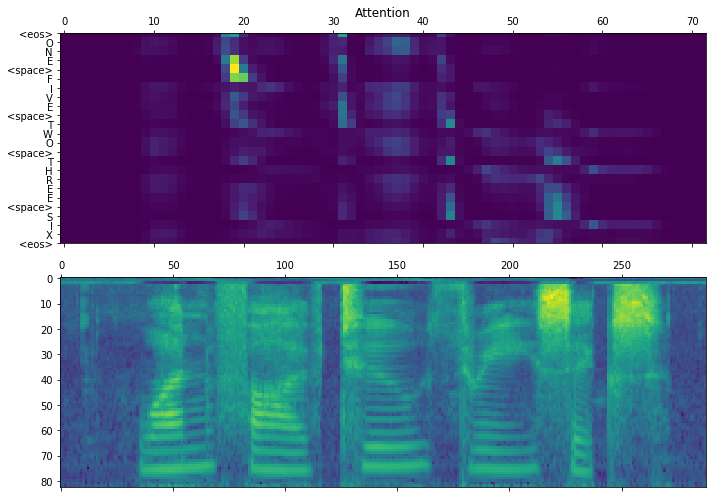

In [46]:
# Attention plot
x = torch.as_tensor(fbank).unsqueeze(0)
y = result[0].yseq.unsqueeze(0)
attn = model.calculate_all_attentions(x, [len(fbank)], y)[0]

# plot
fig, ax = plt.subplots(2, figsize=(10, 7))
ax[0].set_title("Attention")
ax[0].matshow(attn, aspect="auto")
txt = [vocab[int(i)] for i in y[0]]
ax[0].set_yticks(range(len(txt)))
ax[0].set_yticklabels(txt)
ax[1].matshow(fbank.T[::-1], aspect="auto")
fig.tight_layout()

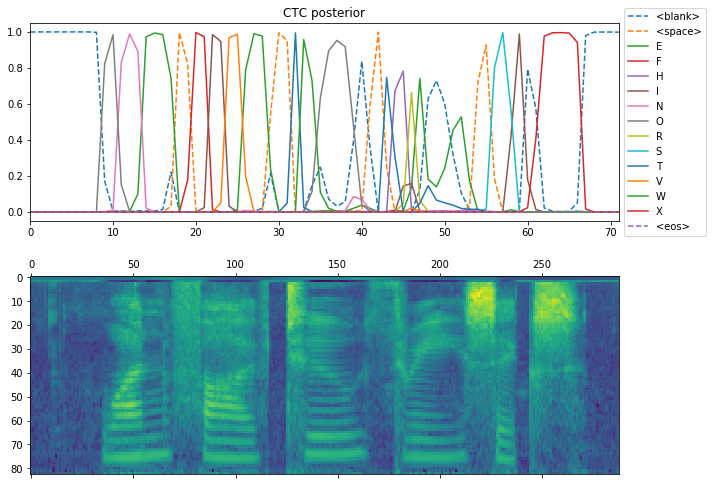

In [70]:
# CTC posterior plot
with torch.no_grad():
    logp = model.ctc.log_softmax(encoded.unsqueeze(0))[0]
    prob = logp.exp_().numpy()

fig, ax = plt.subplots(2, figsize=(10, 7))
ax[0].set_title("CTC posterior")
vs = set(int(y) for y in result[0].yseq)
vs.add(0)
for n, i in enumerate(vs):
    v = vocab[i]
    ax[0].plot(prob[:, i], label=v, linestyle="-" if len(v) == 1 else "--")
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_xlim(0, len(encoded)-1)
ax[1].matshow(fbank.T[::-1], aspect="auto")
fig.tight_layout()

# 5 Extend ESPnet for your research

1. Python library structure
2. Define your new model (Transformer)
3. Training
4. Decoding

## 5.1 Python library structure under `espnet`

- nets: neural networks
- bin: command line tools
- transform: pre/post processing (data augumentation, frontend, etc)
- asr, lm, mt, tts: task specific procedures (train, decode, etc)
- utils: others

Let's extend `nets` with your new ASR model

In [271]:
!tree -L 1 espnet/espnet | grep -v pycache

espnet/espnet
├── asr
├── bin
├── __init__.py
├── lm
├── mt
├── nets
├── transform
├── tts
└── utils

9 directories, 1 file


## 5.2 Define your new ASR model

Each task defines its own interfaces for new models

In [295]:
ls espnet/espnet/nets/*interface.py

espnet/espnet/nets/asr_interface.py  espnet/espnet/nets/scorer_interface.py
espnet/espnet/nets/lm_interface.py   espnet/espnet/nets/tts_interface.py
espnet/espnet/nets/mt_interface.py


Let's define minimal Transformer that implements ASRInterface

In [14]:
import torch
from espnet.nets.asr_interface import ASRInterface
from espnet.nets.pytorch_backend.transformer.encoder import Encoder
from espnet.nets.pytorch_backend.transformer.decoder import Decoder
from espnet.nets.pytorch_backend.transformer.mask import subsequent_mask
from espnet.nets.pytorch_backend.transformer.label_smoothing_loss import LabelSmoothingLoss
from espnet.nets.pytorch_backend.nets_utils import make_pad_mask
from espnet.nets.pytorch_backend.nets_utils import th_accuracy


class ASRTransformer(ASRInterface, torch.nn.Module):
    def __init__(self, idim, odim):
        torch.nn.Module.__init__(self)
        self.encoder = Encoder(idim, input_layer="linear")
        self.decoder = Decoder(odim)
        self.criterion = LabelSmoothingLoss(odim, -1, 0.2, True)
        self.sos = odim - 1
        self.eos = odim - 1
        self.ignore_id=-1

    # for training
    def forward(self, xs_pad, ilens, ys_pad):
        """Compute scalar loss for backprop"""
        src_mask = (~make_pad_mask(ilens.tolist())).to(xs_pad.device).unsqueeze(-2)
        hs_pad, hs_mask = self.encoder(xs_pad, src_mask)

        ys_in_pad, ys_out_pad = self.add_sos_eos(ys_pad)
        ys_mask = self.target_mask(ys_in_pad)
        pred_pad, pred_mask = self.decoder(ys_in_pad, ys_mask, hs_pad, hs_mask)

        loss = self.criterion(pred_pad, ys_out_pad)
        self.acc = th_accuracy(pred_pad.view(-1, pred_pad.size(-1)), ys_out_pad, ignore_label=self.ignore_id)
        return loss
    
    # for decoding
    def encode(self, feat):
        """Encode speech feature."""
        return self.encoder(feat.unsqueeze(0), None)[0][0]

    def scorers(self):
        """Scorer used in beam search"""
        return {"decoder": self.decoder}

    def add_sos_eos(self, ys_pad):
        from espnet.nets.pytorch_backend.nets_utils import pad_list
        eos = ys_pad.new([self.eos])
        sos = ys_pad.new([self.sos])
        ys = [y[y != self.ignore_id] for y in ys_pad]  # parse padded ys
        ys_in = [torch.cat([sos, y], dim=0) for y in ys]
        ys_out = [torch.cat([y, eos], dim=0) for y in ys]
        return pad_list(ys_in, self.eos), pad_list(ys_out, self.ignore_id)

    def target_mask(self, ys_in_pad):
        ys_mask = ys_in_pad != self.ignore_id
        m = subsequent_mask(ys_mask.size(-1), device=ys_mask.device).unsqueeze(0)
        return ys_mask.unsqueeze(-2) & m

## 5.3 Training

Train the model with prepared datasets in the section 3.2

In [15]:
# create minibatch data loader
import json
import kaldiio
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from espnet.utils.training.batchfy import make_batchset

root = "espnet/egs/an4/asr1"
with open(root + "/dump/train_nodev/deltafalse/data.json", "r") as f:
    train_json = json.load(f)["utts"]
with open(root + "/dump/train_dev/deltafalse/data.json", "r") as f:
    dev_json = json.load(f)["utts"]

batch_size = 16
trainset = make_batchset(train_json, batch_size)
devset = make_batchset(dev_json, batch_size)

def collate(minibatch):
    fbanks = []
    tokens = []
    for key, info in minibatch[0]:
        fbanks.append(torch.tensor(kaldiio.load_mat(info["input"][0]["feat"])))
        tokens.append(torch.tensor([int(s) for s in info["output"][0]["tokenid"].split()]))
    ilens = torch.tensor([x.shape[0] for x in fbanks])
    return pad_sequence(fbanks, batch_first=True), ilens, pad_sequence(tokens, batch_first=True)

train_loader = DataLoader(trainset, collate_fn=collate, shuffle=True, pin_memory=True)
dev_loader = DataLoader(devset, collate_fn=collate, pin_memory=True)

In [16]:
# training iteration
import numpy
from torch.nn.utils.clip_grad import clip_grad_norm_

model = ASRTransformer(83, 30)
model.cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98))
n_epoch = 30
for epoch in range(n_epoch):
    acc = []
    model.train()
    for data in train_loader:
        loss = model(*[d.cuda() for d in data])
        optim.zero_grad()
        loss.backward()
        acc.append(model.acc)
        norm = clip_grad_norm_(model.parameters(), 10.0)
        optim.step()
    train_acc = numpy.mean(acc)

    acc = []
    model.eval()
    for data in dev_loader:
        model(*[d.cuda() for d in data])
        acc.append(model.acc)
    valid_acc = numpy.mean(acc)
    print(f"epoch: {epoch}, train acc: {train_acc:.3f}, dev acc: {valid_acc:.3f}")

epoch: 0, train acc: 0.542, dev acc: 0.576
epoch: 1, train acc: 0.648, dev acc: 0.646
epoch: 2, train acc: 0.694, dev acc: 0.684
epoch: 3, train acc: 0.726, dev acc: 0.709
epoch: 4, train acc: 0.746, dev acc: 0.716
epoch: 5, train acc: 0.763, dev acc: 0.729
epoch: 6, train acc: 0.781, dev acc: 0.735
epoch: 7, train acc: 0.792, dev acc: 0.747
epoch: 8, train acc: 0.806, dev acc: 0.745
epoch: 9, train acc: 0.815, dev acc: 0.771
epoch: 10, train acc: 0.829, dev acc: 0.757
epoch: 11, train acc: 0.829, dev acc: 0.749
epoch: 12, train acc: 0.840, dev acc: 0.771
epoch: 13, train acc: 0.847, dev acc: 0.764
epoch: 14, train acc: 0.854, dev acc: 0.781
epoch: 15, train acc: 0.861, dev acc: 0.764
epoch: 16, train acc: 0.864, dev acc: 0.741
epoch: 17, train acc: 0.862, dev acc: 0.760
epoch: 18, train acc: 0.871, dev acc: 0.775
epoch: 19, train acc: 0.879, dev acc: 0.756
epoch: 20, train acc: 0.880, dev acc: 0.771
epoch: 21, train acc: 0.881, dev acc: 0.770
epoch: 22, train acc: 0.889, dev acc: 0.76

## 5.4 Decoding and Evaluation

TODO: beam search
TODO: CER computation

## Summary

Top 3 reasons to use ESPnet for your research

1. Many pretrained models
1. Community-driven development
1. Try it today https://colab.research.google.com/drive/1YA8Cf3_mX41Ku5D01bHOynzDw9gIyWEa

## TODO

- explain beam search (figure, visualization?)
- custom model decoding
- li10 demo/introduction. Maybe create `6. Advanced topics`?


## TODO: References

Kaldi

Corpora

NOTE: Aachen の toolkit も参考に，変な予備知識がさらに必要になる

NOTE: CNTK の ICASSP tutorial (Dong Yuのページにある)

In [0]:
import os
import kaldiio
from IPython.display import Audio


try:
  d = os.getcwd()
  os.chdir(root)
  sr, wav = kaldiio.load_scp("data/test/wav.scp")[key]
finally:
  os.chdir(d)
Audio(wav, rate=sr)